In [3]:
import pickle
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from sklearn.utils import shuffle
import tensorflow as tf 
from tqdm import tqdm_notebook
import matplotlib.image as mpimg
import glob
import os

In [4]:
#Load dataset for training
training_file = './dataset/train.p'
validation_file = './dataset/valid.p'
testing_file = './dataset/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

x_train, y_train = train['features'], train['labels']
x_valid, y_valid = valid['features'], valid['labels']
x_test, y_test = test['features'], test['labels']

assert(len(x_train) == len(y_train))
assert(len(x_valid) == len(y_valid))
assert(len(x_test) == len(y_test))

In [5]:
### Provide a basic summary of the dataset using Python, Numpy and Pandas 
# TODO: Number of training examples
n_train = len(x_train)

# TODO: Number of validation examples
n_validation = len(x_valid)

# TODO: Number of testing examples.
n_test = len(x_test)

# TODO: What's the shape of an traffic sign image?
image_shape = x_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [6]:
#Load .csv file
signnames = pd.read_csv('signnames.csv')
signnames

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)
5,5,Speed limit (80km/h)
6,6,End of speed limit (80km/h)
7,7,Speed limit (100km/h)
8,8,Speed limit (120km/h)
9,9,No passing


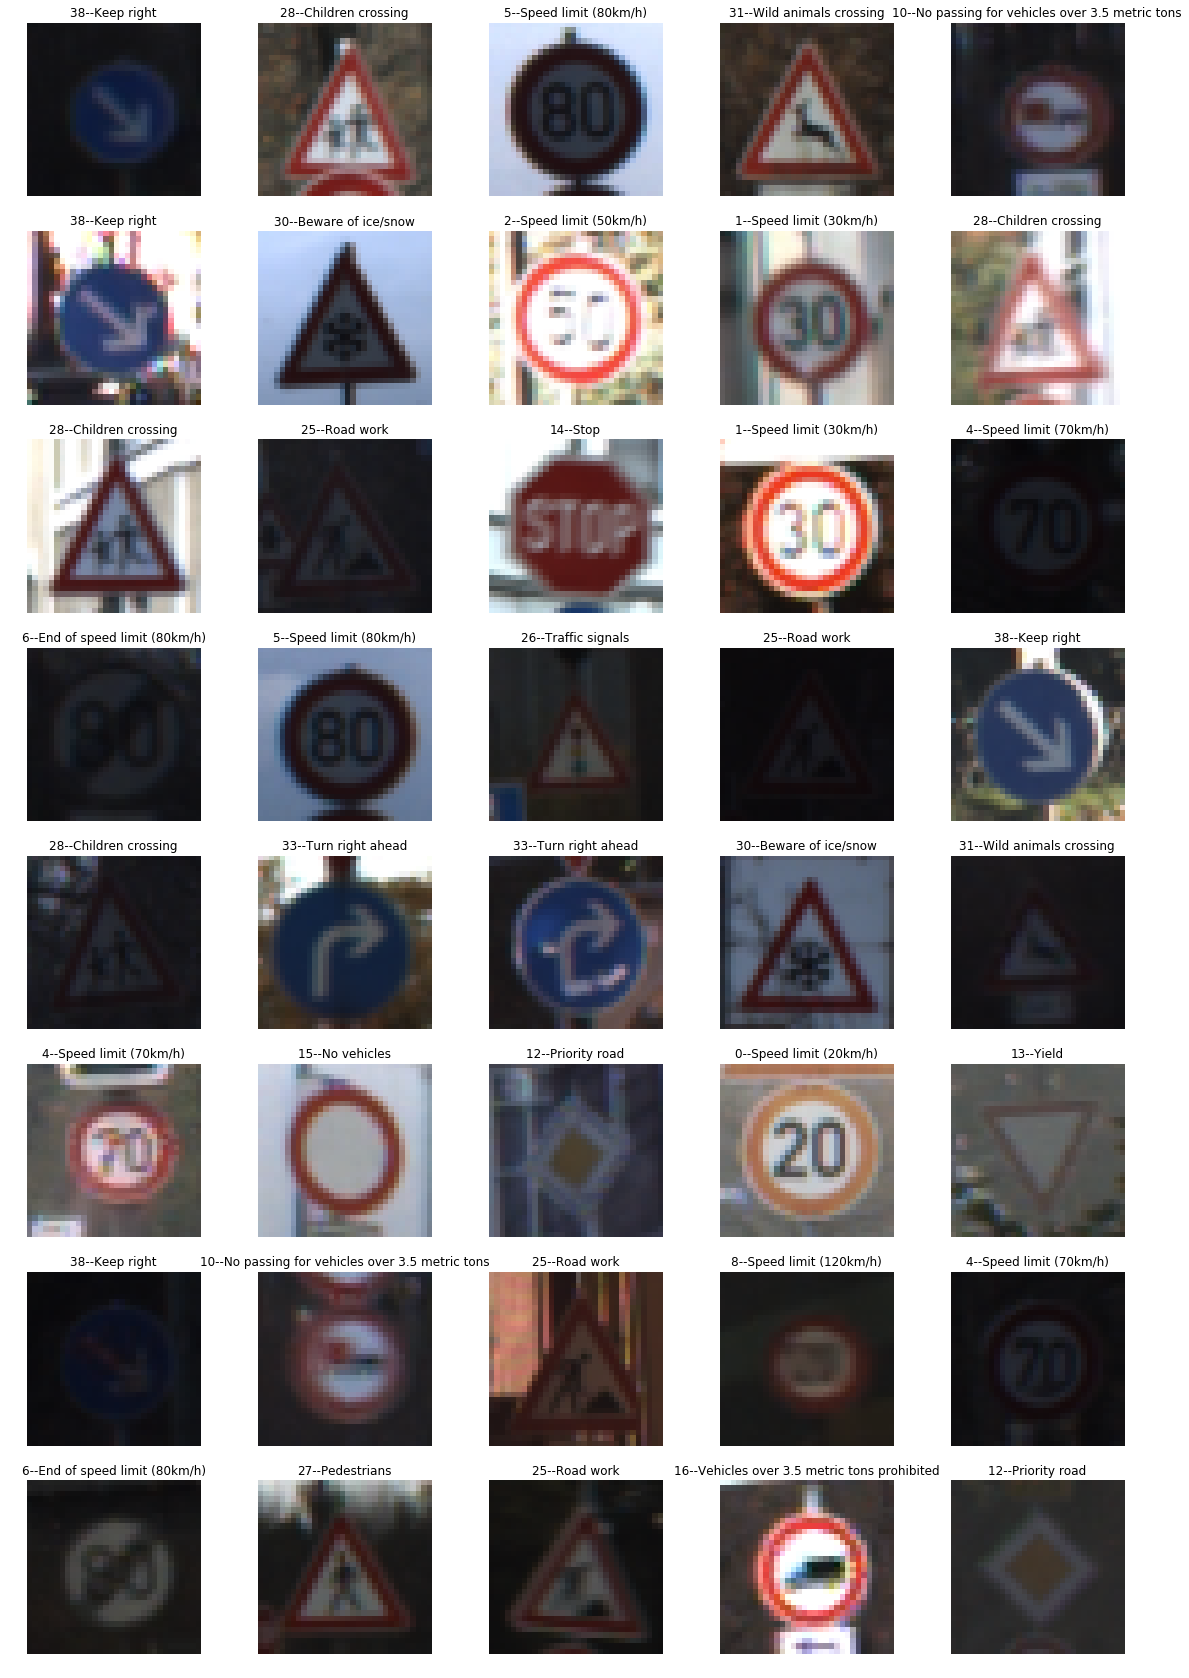

In [7]:
### Data exploration visualization code. Displays images
row_show, col_show = [8, 5]
fig, axes = plt.subplots(row_show, col_show, figsize=(20,30))
axes = axes.ravel()

for i in range(row_show * col_show):
    index = random.randint(0, len(x_train))
    image = x_train[index]
    axes[i].imshow(image)
    axes[i].set_title(str(y_train[index]) + '--' + signnames.iloc[y_train[index]]['SignName'])
    axes[i].axis('off')

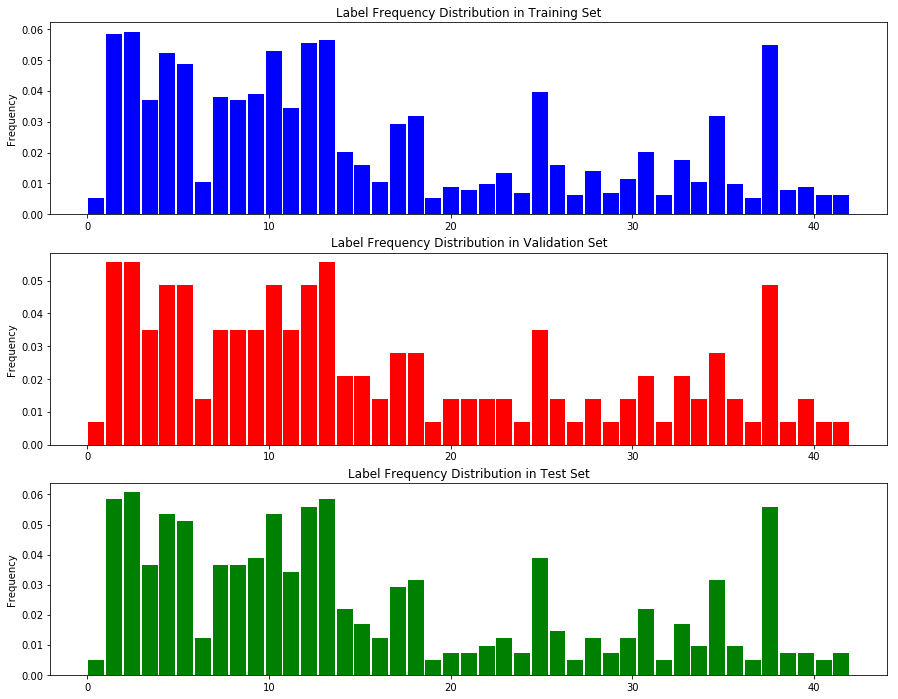

In [17]:
#Create a historgram distribution for each set (training, validation, and test set)
fig, axes = plt.subplots(3, 1, figsize=(15, 12))
plt.setp(axes[0:], ylabel='Frequency')

axes[0].set_title('Label Frequency Distribution in Training Set')
n1, bins1, patches1 = axes[0].hist(y_train, bins = n_classes, density = True, facecolor = 'blue', rwidth = 0.9)
axes[1].set_title('Label Frequency Distribution in Validation Set')
n2, bins2, patches2 = axes[1].hist(y_valid, bins = n_classes, density = True, facecolor = 'red', rwidth = 0.9)
axes[2].set_title('Label Frequency Distribution in Test Set')
n3, bins3, patches3 = axes[2].hist(y_test, bins = n_classes, density = True, facecolor = 'green', rwidth = 0.9)


In [12]:
### Design and Test a Model Architecture
##Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the German Traffic Sign Dataset.

### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

def convertToGrayscale(img):
    """
    Applies the Grayscale transform
    """
    shape = img.shape
    img = img.reshape(-1,shape[2],shape[3])
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray_img = gray_img.reshape(-1, shape[1], shape[2])
    assert(gray_img.shape == (shape[0], shape[1], shape[2]))
    return gray_img

In [13]:
#Histogram Equalization -- CLAHE (Contrast Limited Adaptive Histogram Equalization)

def histogramEqualized(gray_img):
    """
    Create a CLAHE object (Arguments are optional)
    """
    clahe = cv2.createCLAHE(clipLimit=15.0, tileGridSize=(2,2))
    gray_img = np.asarray(list(map(lambda img: clahe.apply(np.reshape(img, (32, 32))), gray_img)))
    return gray_img

In [14]:
#Mean Normalization
def normalizeGrayImage(gray_img):
    """
    Normalize gray image
    """
    #The original Gray_Dataset.dtype maybe np.uint8, convert it to be np.float64
    gray_img = gray_img.astype(np.float64)
    assert(gray_img.dtype == np.float64)
    gray_img = (gray_img - 128) / 128.0
    return gray_img

In [15]:
#Pre-process Pipeline
def preprocessImage(img, prompt):
    print('Convert the '+ prompt + ' images from RGB color space into grayscale color space.')
    images_data = convertToGrayscale(img)
    print('Histogram Equalized the ' + prompt + ' grayscaled images.')
    images_data = histogramEqualized(images_data)
    print('Normalize the '+ prompt + ' grayscaled images.')
    images_data = normalizeGrayImage(images_data)
    return images_data

In [16]:
#Pre-process the images (Convert them from RGB color space into grayscale color space and normalized them)
x_train_RGB = x_train
x_train_normalized = preprocessImage(x_train_RGB, 'training set')
x_valid_RGB = x_valid
x_valid_normalized = preprocessImage(x_valid_RGB, 'validation set')
x_test_RGB = x_test
x_test_normalized = preprocessImage(x_test_RGB, 'test set')

Convert the training set images from RGB color space into grayscale color space.
Histogram Equalized the training set grayscaled images.
Normalize the training set grayscaled images.
Convert the validation set images from RGB color space into grayscale color space.
Histogram Equalized the validation set grayscaled images.
Normalize the validation set grayscaled images.
Convert the test set images from RGB color space into grayscale color space.
Histogram Equalized the test set grayscaled images.
Normalize the test set grayscaled images.


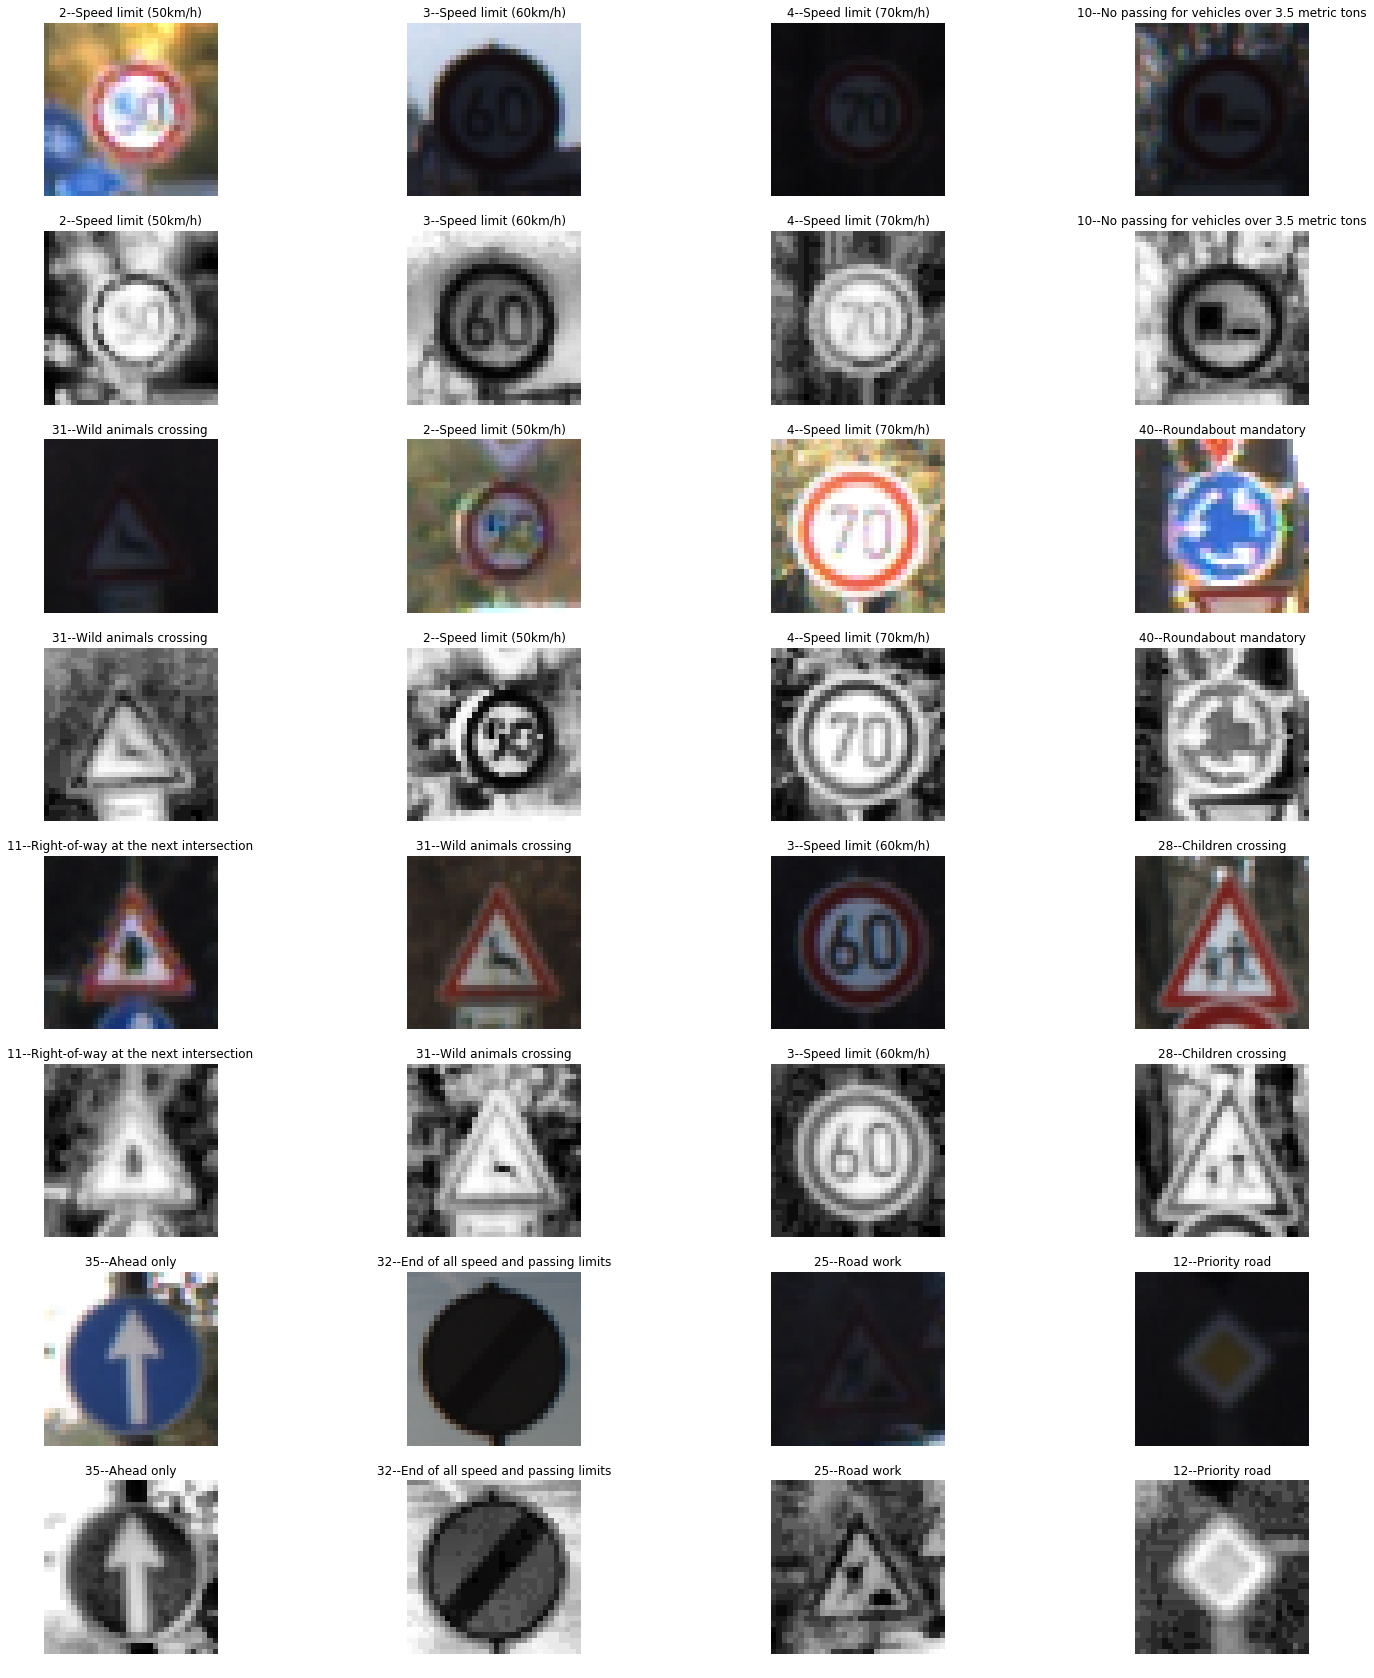

In [17]:
###Compare the preprocessed images with the original
#Randomly choose 32 images from the training set to compare the original images with the grayscale normalized images.

row_show, col_show = [8, 4]
fig, axes = plt.subplots(row_show, col_show, figsize=(25,30))

for i in range(0, row_show, 2):
    for j in range(col_show):
        index = random.randint(0, len(x_train_normalized))
        image_rgb = x_train_RGB[index]
        image_normalized = x_train_normalized[index]
        axes[i, j].imshow(image_rgb)
        axes[i, j].set_title(str(y_train[index]) + '--' + signnames.iloc[y_train[index]]['SignName'])
        axes[i, j].axis('off')
        axes[i+1, j].imshow(image_normalized, cmap='gray')
        axes[i+1, j].set_title(str(y_train[index]) + '--' + signnames.iloc[y_train[index]]['SignName'])
        axes[i+1, j].axis('off')   

In [18]:
x_train_normalized, y_train = shuffle(x_train_normalized, y_train)

In [93]:
#Model Architecture
### Implement LeNet-5 neural network

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob1 = tf.placeholder(tf.float32)
keep_prob2 = tf.placeholder(tf.float32)
keep_prob3 = tf.placeholder(tf.float32)

# Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
mu = 0
sigma = 0.1
    
weights = {
    'conv_1':tf.Variable(tf.truncated_normal([5, 5, 1, 6], mu, sigma)),
    'conv_2':tf.Variable(tf.truncated_normal([5, 5, 6, 16], mu, sigma)),
    'fc_1':tf.Variable(tf.truncated_normal([400, 120], mu, sigma)),
    'fc_2':tf.Variable(tf.truncated_normal([120, 84], mu, sigma)),
    'fc_3':tf.Variable(tf.truncated_normal([84, 43], mu, sigma))        
}
biases = {
    'conv_1':tf.Variable(tf.zeros(6)),
    'conv_2':tf.Variable(tf.zeros(16)),
    'fc_1':tf.Variable(tf.zeros(120)),
    'fc_2':tf.Variable(tf.zeros(84)),
    'fc_3':tf.Variable(tf.zeros(43))
}

# Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
conv_1 = tf.nn.bias_add(tf.nn.conv2d(x, weights['conv_1'], strides=[1,1,1,1], padding='VALID'), biases['conv_1'])
# Activation.
conv_1 = tf.nn.relu(conv_1)
# Pooling. Input = 28x28x6. Output = 14x14x6.
pool_1 = tf.nn.max_pool(conv_1, ksize = [1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

# Layer 2: Convolutional. Output = 10x10x16.
conv_2 = tf.nn.bias_add(tf.nn.conv2d(pool_1, weights['conv_2'], strides=[1,1,1,1], padding='VALID'), biases['conv_2'])
# Activation.
conv_2 = tf.nn.relu(conv_2)
# Pooling. Input = 10x10x16. Output = 5x5x16.
pool_2 = tf.nn.max_pool(conv_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
# Flatten. Input = 5x5x16. Output = 400.
fc_1 = tf.contrib.layers.flatten(pool_2)
# Dropout
fc_1 = tf.nn.dropout(fc_1, keep_prob1)

# Layer 3: Fully Connected. Input = 400. Output = 120.
fc_1 = tf.add(tf.matmul(fc_1, weights['fc_1']), biases['fc_1'])
# Activation.
fc_1 = tf.nn.relu(fc_1)
# Dropout.
fc_1 = tf.nn.dropout(fc_1, keep_prob2)

# Layer 4: Fully Connected. Input = 120. Output = 84.
fc_2 = tf.add(tf.matmul(fc_1, weights['fc_2']), biases['fc_2'])
# Activation.
fc_2 = tf.nn.relu(fc_2)
# Dropout.
fc_2 = tf.nn.dropout(fc_2, keep_prob3)

# Layer 5: Fully Connected. Input = 84. Output = 43.
logits = tf.add(tf.matmul(fc_2, weights['fc_3']), biases['fc_3'])

In [94]:
### Train, Validate and Test the Model
### Calculate and report the accuracy on the training and validation set.
### As final model architecture is selected, the accuracy on the test set will be calculate and evaluated

# Set the hyperparameters for training the model
EPOCHS = 200
BATCH_SIZE = 128
learning_rate = 0.0005
dropout_keep_prob1 = 0.5
dropout_keep_prob2 = 0.5
dropout_keep_prob3 = 0.5

In [95]:
## Training Pipeline
#Create a training pipeline that uses the model to classify Traffic Signs data

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation)

In [96]:
## Model Evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluation(x_data, y_data):
    """
    Evaluate how well the loss and accuracy of the model for a given dataset.
    """
    num_examples = len(x_data)
    shape = x_data.shape
    x_data = x_data.reshape(shape[0],shape[1],shape[2],1)
    total_accuracy = 0.0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = x_data[offset : offset + BATCH_SIZE], y_data[offset : offset + BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x:batch_x, y:batch_y, keep_prob1:1.0, keep_prob2:1.0, keep_prob3:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [97]:
##Train the Model (Use Validation)

### Run the training data through the training pipeline to train the model
### Before each epoch, shuffle the training set
### After each epoch, measure the loss and accuracy of the validation set
### Save the model after training

train_accuracy_list = []
validation_accuracy_list = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(x_train_normalized)
    
    print('Training...\n')
    for i in tqdm_notebook(range(EPOCHS)):
        shape = x_train_normalized.shape
        x_train_normalized = x_train_normalized.reshape(shape[0],shape[1],shape[2],1)
        x_train_normalized, y_train = shuffle(x_train_normalized, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = x_train_normalized[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x : batch_x, y : batch_y, keep_prob1:dropout_keep_prob1, keep_prob2:dropout_keep_prob2, keep_prob3:dropout_keep_prob3})
        train_accuracy = evaluation(x_train_normalized, y_train)
        train_accuracy_list.append(train_accuracy)
        validation_accuracy = evaluation(x_valid_normalized, y_valid)
        validation_accuracy_list.append(validation_accuracy)
        if i%10 == 0:
            print("EPOCH {} ...".format(i+1))
            print("Training Accuracy = {:.3f}".format(train_accuracy))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
    
    saver.save(sess, './traffic-sign-lenet')
    print('Model saved.')

Training...



/Users/racheldam/opt/anaconda2/envs/myenv/lib/python3.5/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


EPOCH 1 ...
Training Accuracy = 0.369
Validation Accuracy = 0.331
EPOCH 11 ...
Training Accuracy = 0.905
Validation Accuracy = 0.859
EPOCH 21 ...
Training Accuracy = 0.947
Validation Accuracy = 0.916
EPOCH 31 ...
Training Accuracy = 0.966
Validation Accuracy = 0.946
EPOCH 41 ...
Training Accuracy = 0.980
Validation Accuracy = 0.958
EPOCH 51 ...
Training Accuracy = 0.984
Validation Accuracy = 0.958
EPOCH 61 ...
Training Accuracy = 0.988
Validation Accuracy = 0.967
EPOCH 71 ...
Training Accuracy = 0.989
Validation Accuracy = 0.967
EPOCH 81 ...
Training Accuracy = 0.991
Validation Accuracy = 0.967
EPOCH 91 ...
Training Accuracy = 0.992
Validation Accuracy = 0.972
EPOCH 101 ...
Training Accuracy = 0.993
Validation Accuracy = 0.969
EPOCH 111 ...
Training Accuracy = 0.993
Validation Accuracy = 0.969
EPOCH 121 ...
Training Accuracy = 0.994
Validation Accuracy = 0.971
EPOCH 131 ...
Training Accuracy = 0.995
Validation Accuracy = 0.969
EPOCH 141 ...
Training Accuracy = 0.995
Validation Accuracy

In [98]:
#The final accuracy on the training set is over 99.6% and the accuracy
#on the validation set is over 97.4%

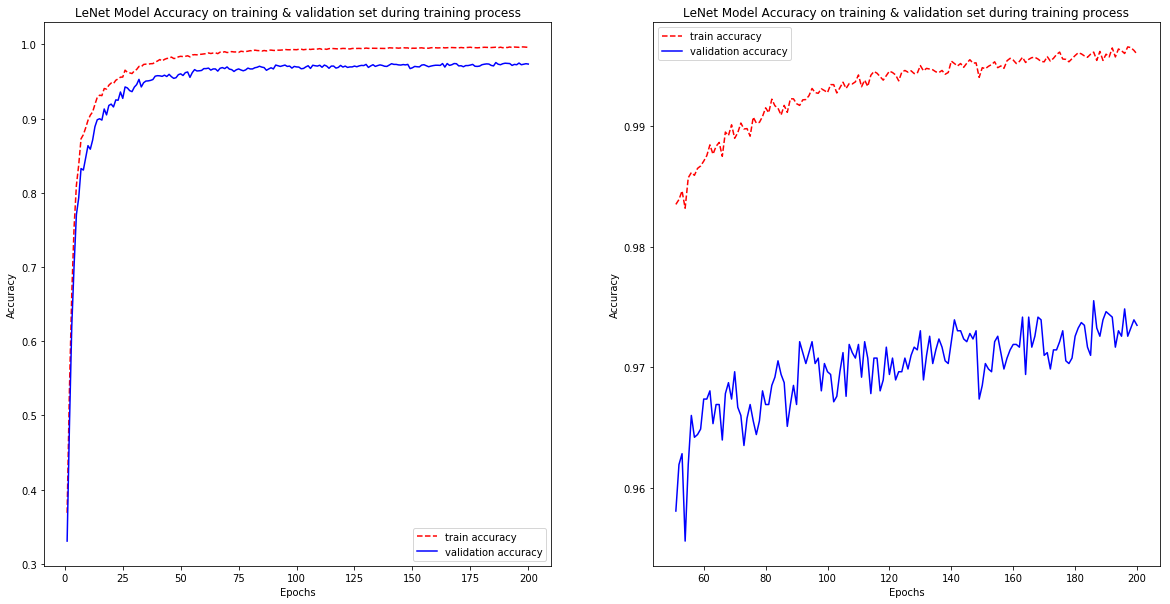

In [165]:
#Create plots of accuracy on training and validation sets
fig, axes = plt.subplots(1,2,figsize = (20,10))
axes[0].plot(range(1,EPOCHS+1),train_accuracy_list,'r--', label='train accuracy')
axes[0].plot(range(1,EPOCHS+1),validation_accuracy_list,'b-', label='validation accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].set_title('LeNet Model Accuracy on training & validation set during training process')
axes[1].plot(range(51,EPOCHS+1),train_accuracy_list[50:],'r--', label='train accuracy')
axes[1].plot(range(51,EPOCHS+1),validation_accuracy_list[50:],'b-', label='validation accuracy')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].set_title('LeNet Model Accuracy on training & validation set during training process')
plt.show()

In [148]:
#Evaluate the Model
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluation(x_test_normalized, y_test)
    print('Test Accuracy = {:.3f}'.format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./traffic-sign-lenet
Test Accuracy = 0.956


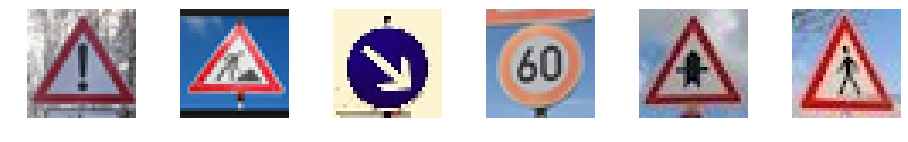

In [150]:
#Test a Model on New Images

### Load the images and plot them here.
### Feel free to use as many code cells as needed.

fig, axes = plt.subplots(1, 6, figsize=(16, 2))
images = []
for i, img in enumerate(sorted(glob.glob('./data-image/*.jpg'))):
    image = cv2.imread(img)
    resized_image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (32,32))
    axes[i].imshow(resized_image)
    axes[i].axis('off')
    images.append(resized_image)
    
# images = np.asarray(images, dtype=np.uint8)
images = np.asarray(images)
y_images = np.array([18, 25, 38, 3, 11, 27])

In [151]:
#Predict the Sign Type for Each Image

### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.
# Preprocess the new image dataset
images_normalized = preprocessImage(images, 'Test new images')

Convert the Test new images images from RGB color space into grayscale color space.
Histogram Equalized the Test new images grayscaled images.
Normalize the Test new images grayscaled images.


In [152]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    for i in range(len(images_normalized)):
        test_image = images_normalized[i].reshape(1, 32, 32, 1)
        predict_id = sess.run(tf.argmax(tf.nn.softmax(logits), 1), feed_dict={x:test_image, keep_prob1:1.0, keep_prob2:1.0, keep_prob3:1.0})
        print("My model predict the {} image's sign type is ".format(i+1)+ str(int(predict_id)) + "--" + signnames.iloc[int(predict_id)]['SignName'])


INFO:tensorflow:Restoring parameters from ./traffic-sign-lenet
My model predict the 1 image's sign type is 18--General caution
My model predict the 2 image's sign type is 25--Road work
My model predict the 3 image's sign type is 38--Keep right
My model predict the 4 image's sign type is 3--Speed limit (60km/h)
My model predict the 5 image's sign type is 11--Right-of-way at the next intersection
My model predict the 6 image's sign type is 27--Pedestrians


In [153]:
#Analyze Performance

### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    images_test_accuracy = evaluation(images_normalized, y_images)
    print('New Images Test Accuracy = {:.3f}'.format(images_test_accuracy))

INFO:tensorflow:Restoring parameters from ./traffic-sign-lenet
New Images Test Accuracy = 1.000


In [154]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    top_k_probabilities = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=5), feed_dict={x:images_normalized.reshape(-1,32,32,1), keep_prob1:1.0, keep_prob2:1.0, keep_prob3:1.0})

print(top_k_probabilities)

INFO:tensorflow:Restoring parameters from ./traffic-sign-lenet
TopKV2(values=array([[9.99993563e-01, 6.40021653e-06, 1.17899668e-09, 1.10570320e-09,
        2.41323671e-12],
       [8.89987111e-01, 2.53694542e-02, 1.82868633e-02, 1.66785475e-02,
        1.06799565e-02],
       [1.00000000e+00, 4.28539132e-22, 4.62090478e-29, 5.36772216e-32,
        1.19989578e-32],
       [9.99383211e-01, 3.71679722e-04, 2.33131097e-04, 7.85899465e-06,
        4.03477588e-06],
       [9.98716116e-01, 1.15578249e-03, 1.02735816e-04, 1.83879783e-05,
        3.07487130e-06],
       [9.40393925e-01, 4.37389053e-02, 1.27871726e-02, 2.95880972e-03,
        1.17590833e-04]], dtype=float32), indices=array([[18, 26, 11, 27, 25],
       [25, 10, 39, 20,  3],
       [38, 34, 36, 17, 14],
       [ 3,  2,  5,  1, 38],
       [11, 27, 18, 30, 24],
       [27, 18, 24, 26, 11]], dtype=int32))


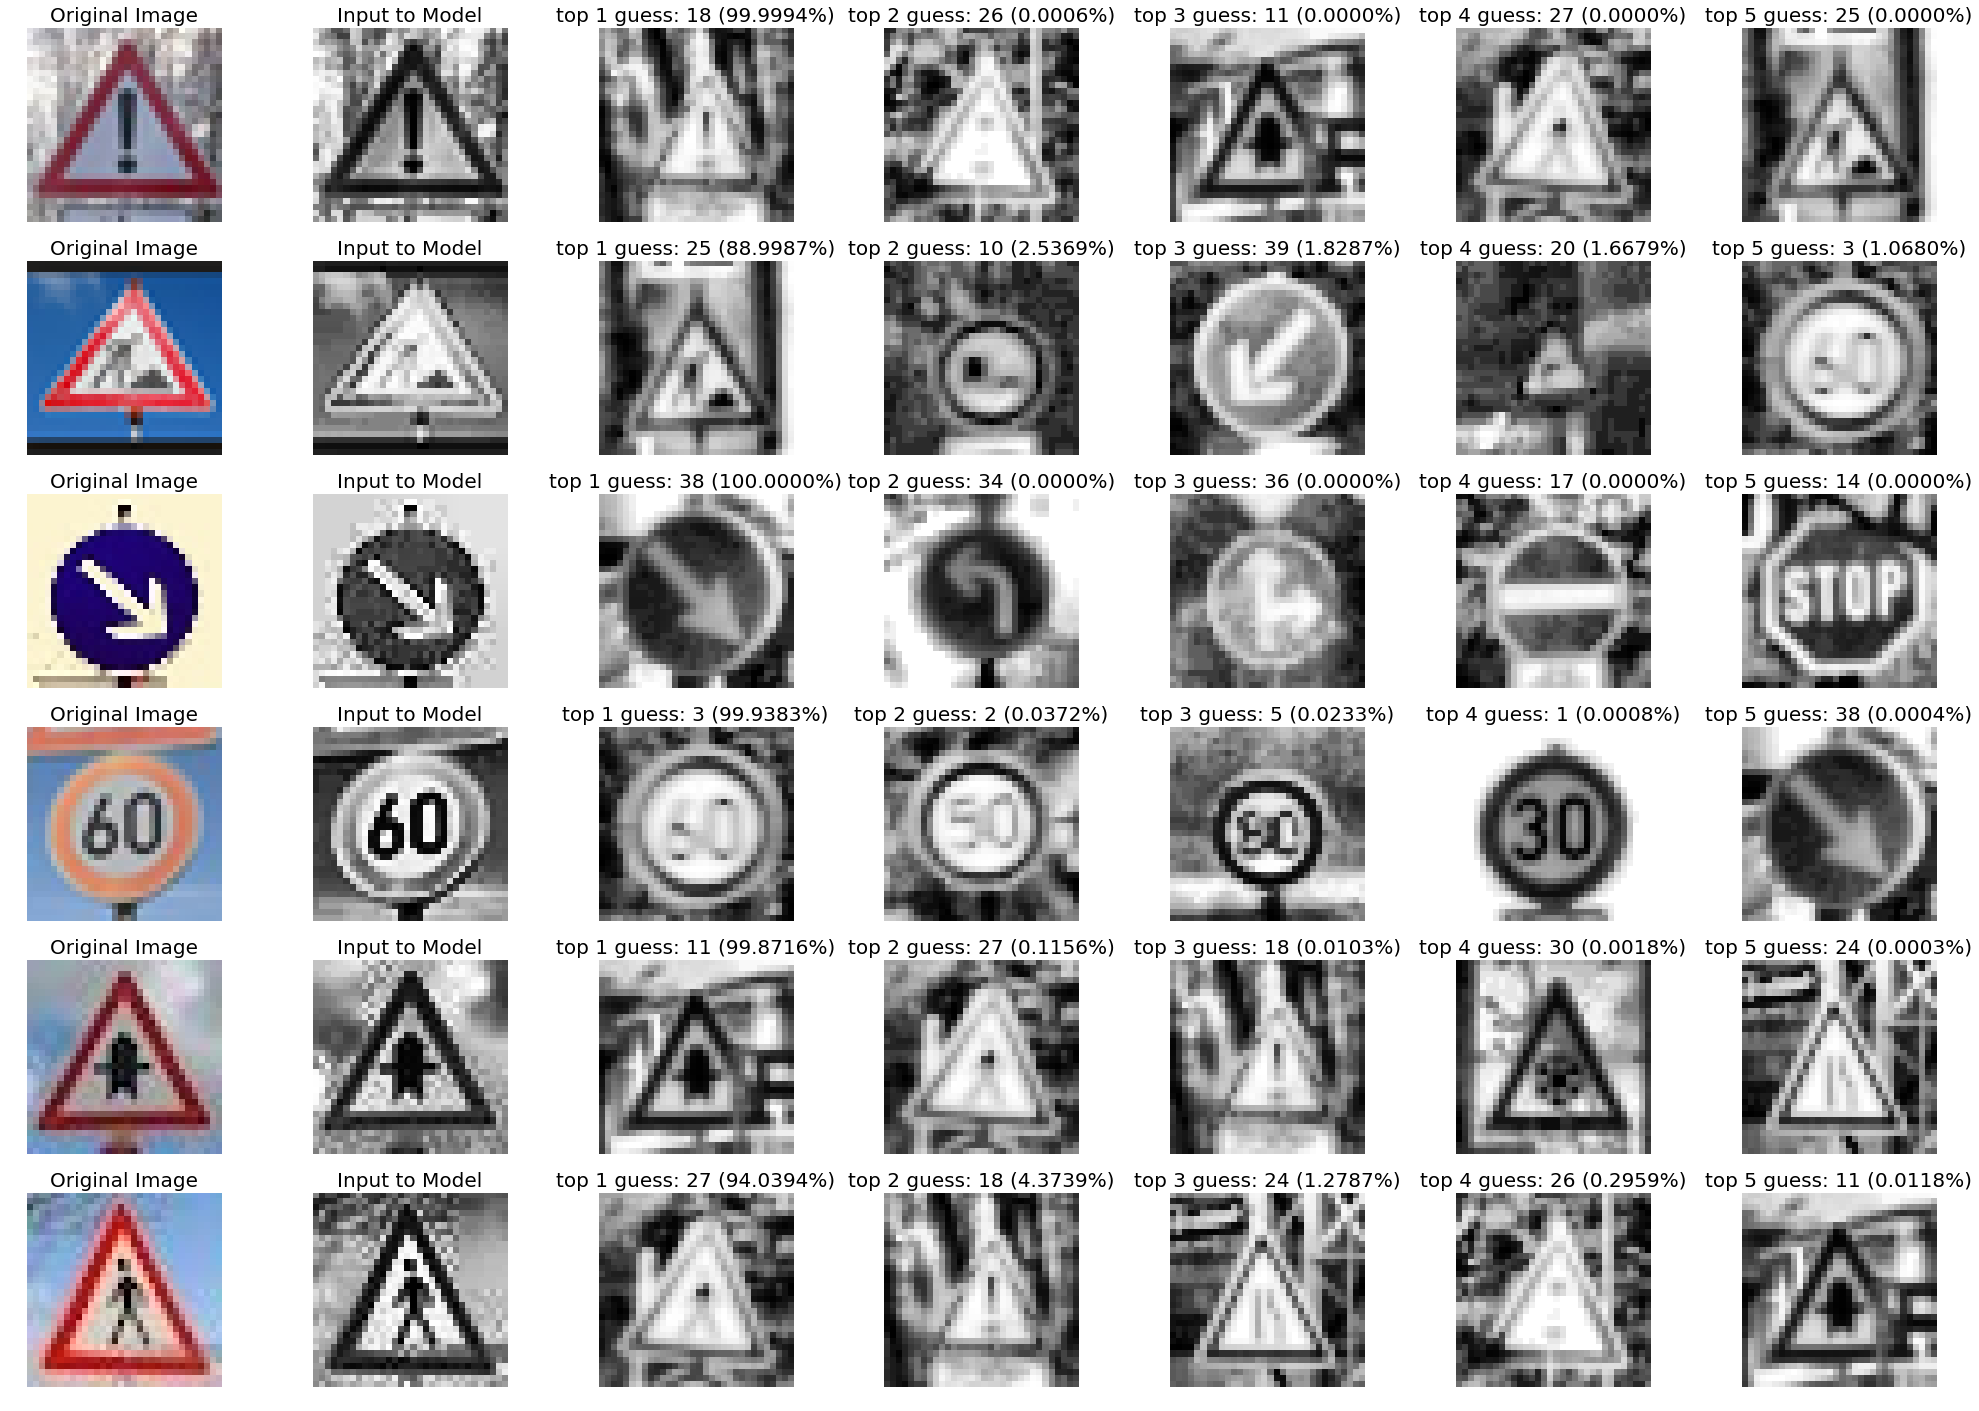

In [155]:
fig, axes = plt.subplots(len(images),7, figsize=(35, 25))

for i, img in enumerate(images):
    axes[i,0].axis('off')
    axes[i,0].imshow(img)
    axes[i,0].set_title('Original Image', fontsize=20)
    axes[i,1].axis('off')
    axes[i,1].imshow(images_normalized[i], cmap='gray')
    axes[i,1].set_title('Input to Model', fontsize=20)
    for j in range(5):
        guess = top_k_probabilities[1][i][j]
        index = np.argwhere(y_train == guess)[0]
        axes[i,j+2].axis('off')
        axes[i,j+2].imshow(x_train_normalized[index].squeeze(), cmap='gray')
        axes[i,j+2].set_title('top {} guess: {} ({:.4f}%)'.format(j+1, guess, 100*top_k_probabilities[0][i][j]), fontsize=20)

In [156]:
#Model is very certain when predicting on each of the fice new traffic signs
#by loking at the softmax probabilities for each prediction. In most case. the top 1st guess
#has a probability close to 100%

In [157]:
#Visualize the Neural Network's State with Test Images
### Visualize your network's feature maps here.
# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(img, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint('.'))
        activation = tf_activation.eval(session=sess,feed_dict={x : img,})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

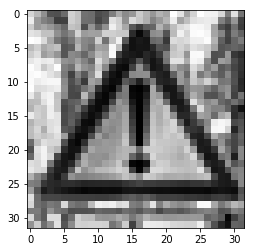

In [158]:
#Grayscale Normalized Image

plt.imshow(images_normalized[0],cmap='gray')

INFO:tensorflow:Restoring parameters from ./traffic-sign-lenet


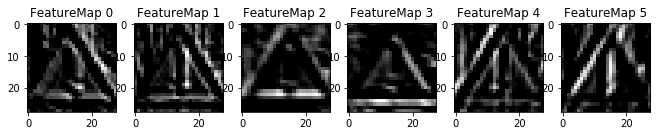

In [159]:
#Convolutional Layer 1
outputFeatureMap(img = images_normalized[0].reshape(1,32,32,1), tf_activation =conv_1)

INFO:tensorflow:Restoring parameters from ./traffic-sign-lenet


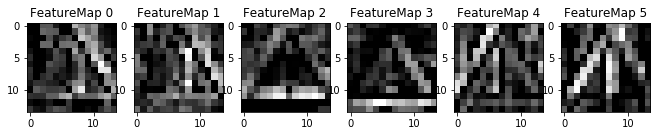

In [160]:
#Max Pooling Layer 1
outputFeatureMap(img = images_normalized[0].reshape(1,32,32,1), tf_activation = pool_1)

INFO:tensorflow:Restoring parameters from ./traffic-sign-lenet


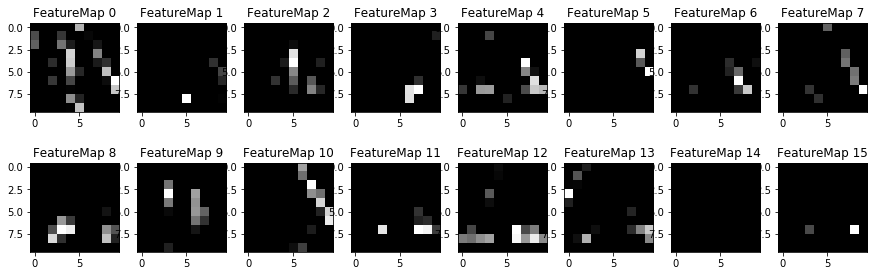

In [161]:
#Convolutional Layer 2
outputFeatureMap(img = images_normalized[0].reshape(1,32,32,1), tf_activation = conv_2)

INFO:tensorflow:Restoring parameters from ./traffic-sign-lenet


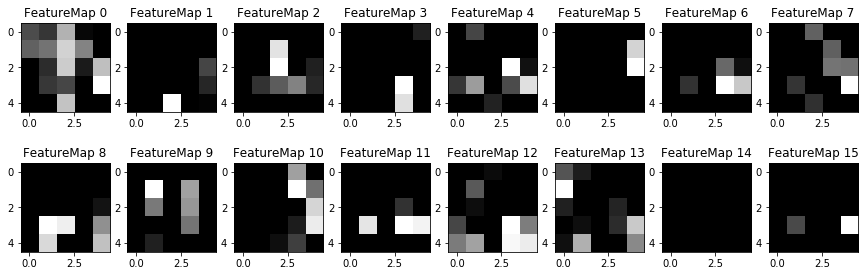

In [162]:
#Max Pooling Layer 2
outputFeatureMap(img = images_normalized[0].reshape(1,32,32,1), tf_activation = pool_2)

In [163]:
#We can see that the Convoltional Layer 1 network is mainly focusing on the edges of the triangular signs and the inner exclamation mark.
#We can see that the max pooling operation reduce the size of the input, and allow the neural network to focus on only the most important elements, in this case, the edges of the signs and the inner exclamation mark.
#It is rather hard to determine what the neural network is focusing on in convolutional layer 2 and max pooling layer 2. In these layers, the model is focusing on more abstract and high-level information.